In [49]:
import pandas as pd
import numpy as np

In [50]:
df = pd.read_csv("../Dataset/Reviews.csv")

### 1. Data Preprocessing

In [51]:
df = df.dropna() # Dropping all rows having Nan values
df = df[df['Score'] != 3] # Dropping all rows havinng Score=3
df['Positivity'] = np.where(df['Score'] > 3, 1, 0) # Creating a new column 'Positivity'
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Positivity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Positivity'], random_state = 0)

print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)
print('Y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', y_test.shape)

X_train first entry: 

 I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


X_train shape:  (394329,)
Y_train shape:  (394329,)
X_test shape:  (131444,)
Y_test shape:  (131444,)


In [53]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
vect = count_vect.fit(X_train)

In [8]:
vocab_size = len(vect.get_feature_names())
print(vocab_size)

102135


In [9]:
print(dict(list(vect.vocabulary_.items())[0: 10]))

{'love': 57457, 'this': 91923, 'drink': 34560, 'mix': 61593, 'don': 34019, 'like': 56429, 'coffee': 25856, 'used': 96480, 'to': 92621, 'be': 16735}


In [ ]:
ex = [vect.vocabulary_.get(i.lower()) for i in X_train[0].split() 
      if vect.vocabulary_.get(i.lower()) != None]

In [24]:
k = 10000
vocab_dict = vect.vocabulary_
#short_vocab_dict = dict(list(vocab_dict.items())[0: k])

In [25]:
def sent_to_num(sentences):
    
    res = []
    
    for sent in sentences:
        nos_list = [vocab_dict.get(i.lower()) for i in sent.split() if vocab_dict.get(i.lower()) != None]
        res.append(nos_list)
    
    return res

In [27]:
X_train_nos = sent_to_num(X_train)

In [28]:
X_test_nos = sent_to_num(X_test)

In [29]:
# Create a 2D Tensor to be processed by the embedding layer
from keras.preprocessing import sequence

X_train_tensor = sequence.pad_sequences(X_train_nos,maxlen=500)
X_test_tensor = sequence.pad_sequences(X_test_nos,maxlen=500)

In [30]:
print(X_train_tensor.shape)
print(X_test_tensor.shape)

print(X_train_tensor[16])

(394329, 500)
(131444, 500)
[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0

### 2. Building RNN Model

In [33]:
# Create a Model in Keras

from tensorflow.python.keras.layers import Embedding, SimpleRNN,Dense
from tensorflow.python.keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size,64))
model.add(SimpleRNN(32))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          6536640   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                3104      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 6,539,777
Trainable params: 6,539,777
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

### 3. Training

In [33]:
from tensorflow.python.keras.callbacks import ModelCheckpoint # Save the best model, fight overfitting
from tensorflow.python.keras.callbacks import EarlyStopping # Save time


checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto',period=1)
earlystop = EarlyStopping(monitor='val_accuracy',patience=1)

hist = model.fit(X_train_tensor,y_train,validation_split=0.2,epochs=10,batch_size=128,callbacks=[checkpoint, earlystop])

Epoch 1/10
2465/2465 [==============================] - 489s 198ms/step - loss: 0.2586 - accuracy: 0.8952 - val_loss: 0.2504 - val_accuracy: 0.8967
Epoch 2/10
2465/2465 [==============================] - 489s 198ms/step - loss: 0.2133 - accuracy: 0.9163 - val_loss: 0.2068 - val_accuracy: 0.9189
Epoch 3/10
2465/2465 [==============================] - 507s 206ms/step - loss: 0.1955 - accuracy: 0.9242 - val_loss: 0.2032 - val_accuracy: 0.9207
Epoch 4/10
2465/2465 [==============================] - 505s 205ms/step - loss: 0.1793 - accuracy: 0.9314 - val_loss: 0.1965 - val_accuracy: 0.9227
Epoch 5/10
2465/2465 [==============================] - 506s 205ms/step - loss: 0.1685 - accuracy: 0.9363 - val_loss: 0.2368 - val_accuracy: 0.9051


### 4. Visualizing Results

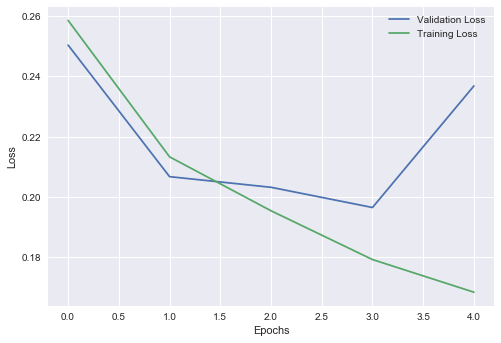

In [34]:
# Visualizing loss

h = hist.history

import matplotlib.pyplot as plt
plt.style.use('seaborn') 
plt.plot(h['val_loss'],label='Validation Loss') 
plt.plot(h['loss'],label='Training Loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend() 
plt.show()

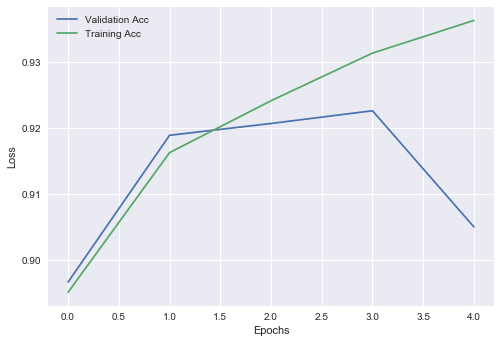

In [35]:
plt.plot(h['val_accuracy'],label='Validation Acc') 
plt.plot(h['accuracy'],label='Training Acc') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend() 
plt.show()

In [34]:
model.load_weights('best_model.h5')

In [37]:
model.evaluate(X_train_tensor,y_train)

12323/12323 [==============================] - 406s 33ms/step - loss: 0.1576 - accuracy: 0.9408


[0.15758246183395386, 0.9407652020454407]

In [144]:
model.evaluate(X_test_tensor,y_test)

### 5. Passing a custom review to Model

In [80]:
sample_text = "good taste"

sample_no_list = [vect.vocabulary_.get(i.lower()) for i in sample_text.split() if vect.vocabulary_.get(i.lower()) != None]

In [81]:
from keras.preprocessing import sequence

sample_input = sequence.pad_sequences([sample_no_list],maxlen=500)
print(sample_input)
print(sample_input.shape)

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0 

In [82]:
print(model.predict_classes(sample_input))
print(model.predict(sample_input))
print(model.predict(sample_input).shape)

[[0]]
[[0.05736358]]
(1, 1)


### 6. Converting keras model to .tflite

In [125]:
keras_file = "Food Review Analysis RNN Model"
model.save(keras_file)

INFO:tensorflow:Assets written to: Food Review Analysis RNN Model\assets


INFO:tensorflow:Assets written to: Food Review Analysis RNN Model\assets


In [126]:
tf_model = tf.saved_model.load(keras_file)

In [127]:
concrete_func = tf_model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

In [138]:
concrete_func.inputs[0].set_shape([1,500])
concrete_func.outputs[0].set_shape([1,1])

In [129]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

In [130]:
tflite_model = converter.convert()

In [131]:
open('rnn_model_food_review_analysis.tflite','wb').write(tflite_model)

26241260

In [132]:
interpreter = tf.lite.Interpreter(model_path="rnn_model_food_review_analysis.tflite")
interpreter.allocate_tensors()

In [133]:
# Print input shape and type
print(interpreter.get_input_details()[0]['shape'])  
print(interpreter.get_input_details()[0]['dtype'])  

# Print output shape and type
print(interpreter.get_output_details()[0]['shape']) 
print(interpreter.get_output_details()[0]['dtype']) 

[  1 500]
<class 'numpy.float32'>
[]
<class 'numpy.float32'>


In [134]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [135]:
print(input_details)

[{'name': 'embedding_2_input', 'index': 0, 'shape': array([  1, 500]), 'shape_signature': array([  1, 500]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [136]:
print(output_details)

[{'name': 'Identity', 'index': 45, 'shape': array([], dtype=int32), 'shape_signature': array([], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


### Testing .tflite Model

In [72]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="rnn_model_food_review_analysis.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = sample_input.astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.46767867]]


### Saving Vocab

In [11]:
import pickle

bow_dict = vect.vocabulary_
file = open("vocab_dict.pkl", "wb")
pickle.dump(bow_dict, file)
file.close()

In [12]:
# Reading vocab
read_file = open("vocab_dict.pkl", "rb")
output = pickle.load(read_file)

In [13]:
print(dict(list(output.items())[0: 10]))

{'love': 57457, 'this': 91923, 'drink': 34560, 'mix': 61593, 'don': 34019, 'like': 56429, 'coffee': 25856, 'used': 96480, 'to': 92621, 'be': 16735}


In [20]:
type(output['love'])

numpy.int32

### Saving vocab as .txt

In [21]:
for keys in vect.vocabulary_: 
        output[keys] = int(output[keys]) 

In [24]:
import json

with open('food_review_vocab_word_to_idx_dict.txt', 'w',encoding='UTF-8') as file:
     file.write(json.dumps(output))

In [25]:
with open('food_review_vocab_word_to_idx_dict.txt', 'r') as f:
     data = json.load(f)

In [26]:
type(data)

dict

In [27]:
print(len(data))

102135
